# Course: Introduction to Machine Learning


# Work 1. Clustering Exercise


Link:

https://github.com/gusseppe/master_artificial_intelligence/blob/master/Introduction_to_Machine_Learning/deliverables/work1

## Clustering exercise

1. Preprocess the data

2. Agglomerative Clustering with sklearn

3. K-Means (your own code)

4. K-Modes (your own code)

5. K-Prototype (your own code)

6. Fuzzy clustering (your own code)

7. Validation techniques (using sklearn validation metrics)

## 1. Preprocess the data


Implement your code for reading the arff file in Python and store the information in memory.
Be careful, some of the data sets contain numerical and categorical data and may also
contain missing values. For this exercise it is not necessary to store the class of the data set.
However, for future assignments you will be requested to use the class. In the following
address:
https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.io.arff.loadarff.html

You will find a code for reading and writing arff files in Python. You can implement your own
parser (do not use any other library) or you can analyze the code based on scipy.io
library in the abovementioned link, execute it, and modify it accordingly to your needs. If you
need it, for the numerical datasets, you can transform the continuous variables/attributes into
categorical variables using function pandas.qcut.


### Dataset (numerical and categorical) : Contraceptive Method Choice (cmd.arff)

**Relevant Information:**

   This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not 
   pregnant or do not know if they were at the time of interview. The 
   problem is to predict the current contraceptive method choice 
   (no use, long-term methods, or short-term methods) of a woman based 
   on her demographic and socio-economic characteristics.

**Attribute Information:**

1. Wife's age                     (numerical)
2. Wife's education               (categorical)      1=low, 2, 3, 4=high
3. Husband's education            (categorical)      1=low, 2, 3, 4=high
4. Number of children ever born   (numerical)
5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
6. Wife's now working?            (binary)           0=Yes, 1=No
7. Husband's occupation           (categorical)      1, 2, 3, 4
8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
9. Media exposure                 (binary)           0=Good, 1=Not good
10. Contraceptive method used     (class attribute)  (1=No-use, 2=Long-term, 3=Short-term)

### Read and parse the dataset

In [5]:
import pandas as pd

from urllib import request
from scipy.io import arff
from io import StringIO

# Download the dataset
url = 'https://raw.githubusercontent.com/gusseppe/master_artificial_intelligence/master/Introduction_to_Machine_Learning/deliverables/work1/datasets/datasets/cmc.arff'
raw_dataset = request.urlopen(url).read().decode('utf8') 
raw_dataset = StringIO(raw_dataset)

# Parse the dataset into numpy array
dataset, meta = arff.loadarff(raw_dataset)

# Parse the dataset into pandas DataFrame
df = pd.DataFrame(dataset)
df = df.astype(int)

df.head()

,wage,weducation,heducation,children,wreligion,wworking,hoccupation,living_index,media_exposure,class
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


### Exploratory data analysis (EDA)



**Split up the numerical and categorical data**

In [6]:
# Split up features (X) and response variable (y)
X = df.loc[:, df.columns != 'class']
y = df['class']

# Split up from features (X) the numerical and categorical features 
numerical_features = ['wage', 'children']
categorical_features = [cf for cf in list(X.columns) if cf not in numerical_features]

X_num = X[numerical_features]
X_cat = X[categorical_features]

print(f'# instances: {len(X)} | # features: {len(X.columns)}')
print(f'# num_features: {len(X_num.columns)} | # cat_features: {len(X_cat.columns)}')

# instances: 1473 | # features: 9
# num_features: 2 | # cat_features: 7


**Analyze the numerical features**


There are no numerical features with NaN values.

In [7]:
print(X_num.isnull().sum())

wage        0
children    0
dtype: int64


In the following histogram plot, we can observe that the 'children' feature is skewed to the left, whereas, the 'wage' features is almost similar to a normal distribution.

From this plot we can conclude that, most likely, a function might be applied to 'children' feature to normalize it.

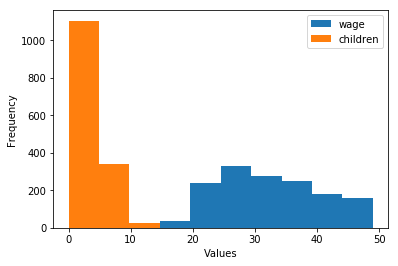

In [8]:
import matplotlib.pyplot as plt 
import seaborn as sns

X_num.plot(kind='hist')
_ = plt.xlabel("Values")

As depicted in the boxplot, we can see that there some outliers in the 'children' feature, likely to be removed later. Furthermore, we can observe that the 'wage' feature is well shaped, it means, similar to a gaussian/normal distribution.

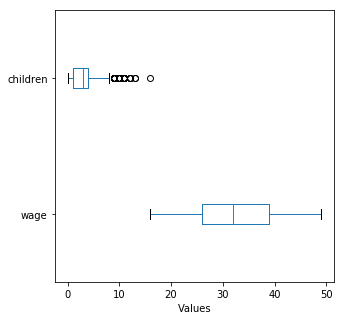

In [9]:
_ = X_num.plot(kind='box',figsize=(5, 5), vert=False)
_ = plt.xlabel("Values")

Using a scatterplot we can find out clusters or groups that appear when plotting two numerical features. However, in this case, this plot does not bring so much information because all the points belong, apparently, to a one cluster. We expect it to has 3 clusters. Nonetheless, we need to analyze also the remaining features (the categorical ones). 

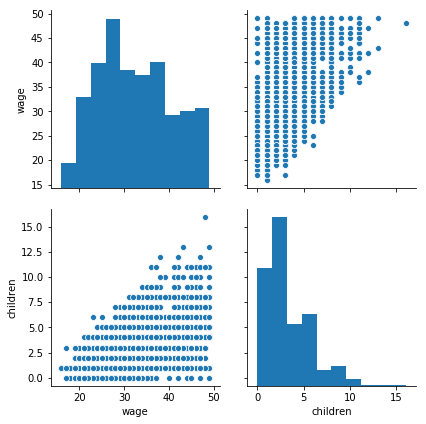

In [10]:
_ = sns.pairplot(X_num, height=3)

**Analyze the categorical features**

There are no categorical features with NaN values.

In [11]:
print(X_cat.isnull().sum())

weducation        0
heducation        0
wreligion         0
wworking          0
hoccupation       0
living_index      0
media_exposure    0
dtype: int64


Let's examine how many levels each categorical feature has. For instance, in the 'wreligion' feature, there are 1253 women that are islamists, and 220 that don't. It means that the dataset is biased on religion; that is, 1253 out of 1473 are Islamists, about 85% of the total data. Those values are important when interpreting the results later.

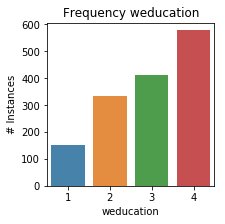

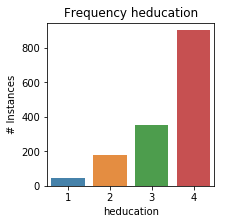

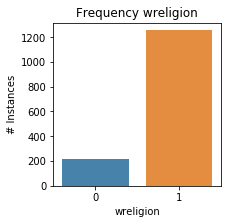

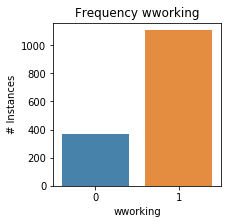

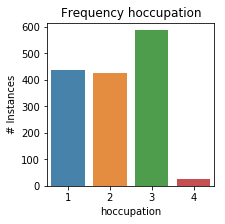

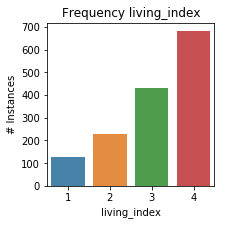

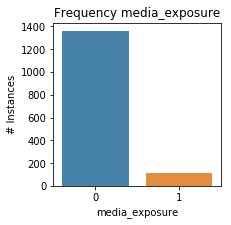

In [12]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (3, 3)

cat_value_counts = {}

for col in X_cat.columns:
  cat_value_counts[col] = X_cat[col].value_counts()
  sns.barplot(cat_value_counts[col].index, cat_value_counts[col].values, alpha=0.9)
  plt.title(f'Frequency {col}')
  plt.ylabel('# Instances')
  plt.xlabel(col)
  plt.show()



### Scaling (numerical features)

Many supervised linear ML models expect features to have a normal distribution (0 mean and unit variance) because if a feature has a different variance and centre, it will dominate and affect the others, making the models unable to learn uniformally across the remaining features. However, unsupervised models expect features to have the same range, it means, the same scale when dealing with distances. When there is a lack of scaling, the distances are not comparable.

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num.values)
X_num_scaled = pd.DataFrame(X_num_scaled, index=X_num.index, columns=X_num.columns)
X_num_scaled.head()

,wage,children
0,-1.038167,-0.110856
1,1.515194,2.858078
2,1.272017,1.585678
3,1.150428,2.433945
4,0.420897,2.009811


### Encoding (categorical features)



First, find binary categorical features as they don't need to be encoded (they already have 2 unique values).


Then, encoding the remaining categorical features with more than 2 levels (categories).

The chosen method is One Hot Encoder. That's because, the number of categories of each categorical feature is at most 4. That's why sparseness (matrix), as a result of the encoding, will be less intense than having many levels. Binary Encoding approach might be used for the latter case.


In [14]:
# Find features with two categories.

binary_cat_features = []
for k,v in cat_value_counts.items():
  print(f'Feature:{k} | # categories: {v.count()}')
  if v.count() == 2:
    binary_cat_features.append(k)

print()
print(f'Binary cat_features: {binary_cat_features}')
remaining_cat_features = list(set(X_cat.columns)-set(binary_cat_features))
print(f'Remaining cat_features: {remaining_cat_features}')

# One hot encoding

# binary_cat_features = ['']
X_cat_encoded = pd.get_dummies(X_cat, columns=remaining_cat_features)
X_cat_encoded.head()

Feature:weducation | # categories: 4
Feature:heducation | # categories: 4
Feature:wreligion | # categories: 2
Feature:wworking | # categories: 2
Feature:hoccupation | # categories: 4
Feature:living_index | # categories: 4
Feature:media_exposure | # categories: 2

Binary cat_features: ['wreligion', 'wworking', 'media_exposure']
Remaining cat_features: ['hoccupation', 'heducation', 'weducation', 'living_index']


,wreligion,wworking,media_exposure,hoccupation_1,hoccupation_2,hoccupation_3,hoccupation_4,heducation_1,heducation_2,heducation_3,heducation_4,weducation_1,weducation_2,weducation_3,weducation_4,living_index_1,living_index_2,living_index_3,living_index_4
0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
2,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
3,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
4,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0


Join both numerical and categorical variables


In [15]:
X_final = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
print(f'# Total features: {len(X_final.columns)}')
X_final.head()

# Total features: 21


,wage,children,wreligion,wworking,media_exposure,hoccupation_1,hoccupation_2,hoccupation_3,hoccupation_4,heducation_1,heducation_2,heducation_3,heducation_4,weducation_1,weducation_2,weducation_3,weducation_4,living_index_1,living_index_2,living_index_3,living_index_4
0,-1.038167,-0.110856,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,1.515194,2.858078,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
2,1.272017,1.585678,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
3,1.150428,2.433945,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0.420897,2.009811,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0


### Visualize the clusters


In order to visualize the clusters, we need to reduce the dimensionality of **X**. We can reduce the dimensions to 3 or 2 as it is not humanly possible to see dimensions greater than those.

We can see that the first two components have the majority of variance, so we consider these two to draw a scatter plot.

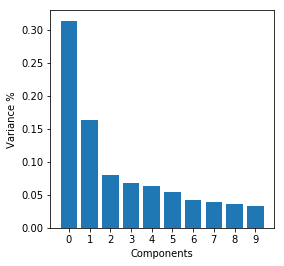

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_final_pca = pca.fit_transform(X_final.values)

list_components = list(range(pca.n_components_))
plt.bar(list_components, pca.explained_variance_ratio_)
plt.xlabel('Components')
plt.ylabel('Variance %')
plt.xticks(list_components)

X_final_pca = pd.DataFrame(X_final_pca)

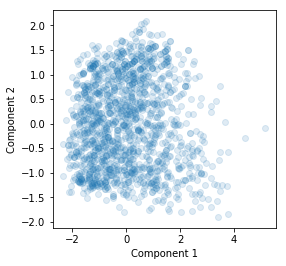

In [46]:
rcParams['figure.figsize'] = (4, 4)
plt.scatter(X_final_pca[0], X_final_pca[1], alpha=.14)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## 2. Agglomerative Clustering with sklearn

Implement in a Python file the code that uses the AgglomerativeClustering from the
sklearn library and apply it to the data of the file. Use Euclidean and Cosine functions and
evaluate what happen when you use complete, average or single linkage.

We can see that with **affinity=cosine** and **linkage={complete, average}**, the algorithm can find better the clusters as shown in the plots.

Explain: https://cmry.github.io/notes/euclidean-v-cosine



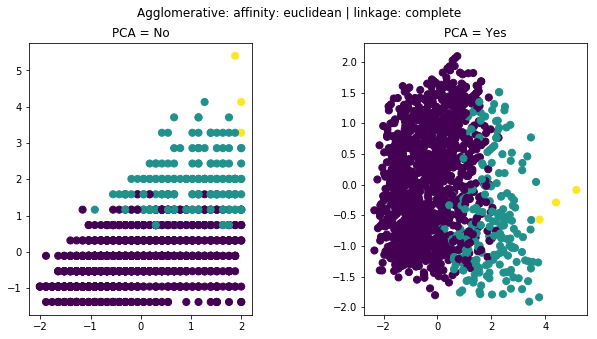

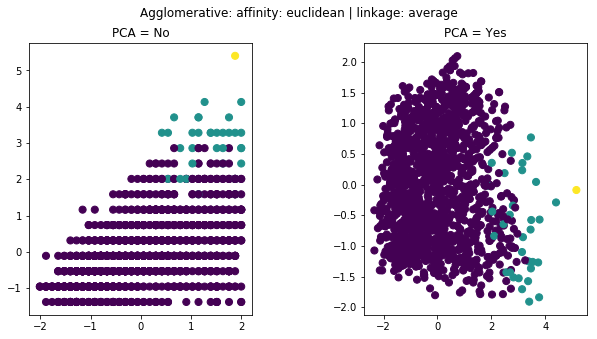

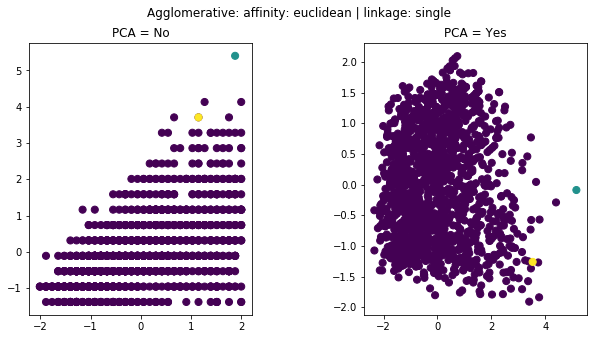

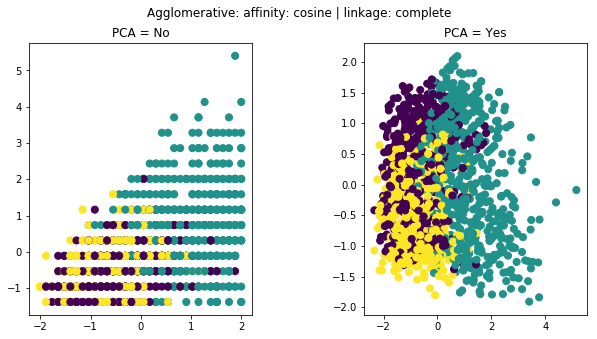

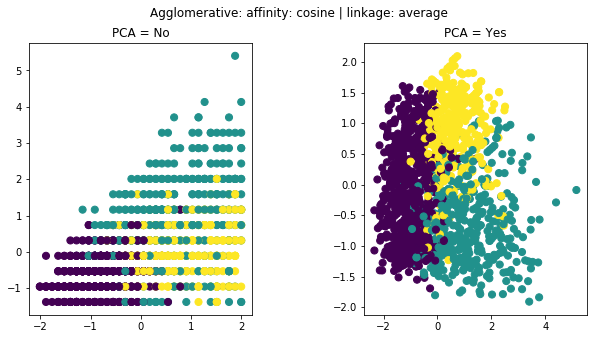

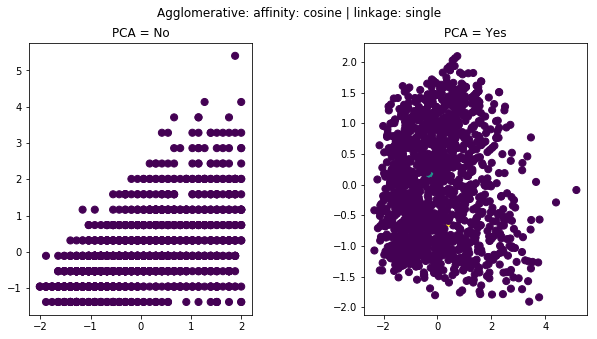

In [97]:
|from sklearn.cluster import AgglomerativeClustering


affinity = ['euclidean', 'cosine']
linkage = ["complete", "average", "single"]

for aff in affinity:
  for link in linkage:
    model = AgglomerativeClustering(affinity=aff, compute_full_tree='auto',
                            connectivity=None, distance_threshold=None,
                            linkage=link, memory=None, n_clusters=3,
                            pooling_func='deprecated')
    model1 = model.fit(X_final)
    model2 = model.fit(X_final_pca)

    fig, ax = plt.subplots(1, 2, 
                           figsize=(10, 5),
                           gridspec_kw={'hspace': 2, 'wspace': 0.5})
    fig.suptitle(f'Agglomerative: affinity: {aff} | linkage: {link}')

    ax[0].scatter(X_final.values[:, 0], X_final.values[:, 1], c=model.labels_,
                s=50, cmap='viridis');
    ax[0].set_title(f'PCA = No')
    

    ax[1].scatter(X_final_pca.values[:, 0], X_final_pca.values[:, 1], c=model2.labels_,
                s=50, cmap='viridis');
    ax[1].set_title(f'PCA = Yes')

    

In [70]:
unique, counts = np.unique(model.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 1135, 1: 49, 2: 289}

## 3. K-Means (your own code)

Implement your own K-Means (KM) algorithm and apply it to the data of the file. Note that you are not allowed to use sklearn library.

### Implementation

In [0]:
import numpy as np

def k_means(X, k, random_state=12):
  
  #Randomly initialize centroids
  random_state = np.random.RandomState(random_state)
  centroids = X[random_state.choice(X.shape[0], k)]
  centroids_updated = centroids.copy()
  
  distances = np.zeros((X.shape[0], k))
  
  while True:
    
    #Cluster assignment step
    for index in range(k):
      distances[:, index] = np.linalg.norm(X-centroids[index], axis=1)


  #   distances = np.array([np.linalg.norm(X-centroids[index], axis=1) \
  #                                    for index in range(k)]).T

    clusters = np.argmin(distances, axis=1)

    # Move centroid step
      
    centroids_updated = np.array([X[clusters == index].mean(axis=0)
                                for index in range(k)])

    if np.all(centroids == centroids_updated):
      break
      
    centroids = centroids_updated
    
  return centroids, clusters


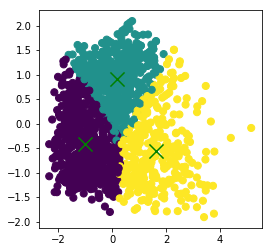

In [47]:
centroids, clusters = k_means(X_final_pca.values, k=3)
plt.scatter(X_final_pca.values[:, 0], X_final_pca.values[:, 1], c=clusters,
            s=50, cmap='viridis');
plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='g', s=200);

In [0]:
# from sklearn.cluster import KMeans

# ks = range(1, 10)
# inertias = []
# for k in ks:

#     model = KMeans(n_clusters=k)
    

#     model.fit(PCA_components.iloc[:,:3])
    

#     inertias.append(model.inertia_)
    
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.show()